In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, Input, Concatenate, Flatten
from tensorflow.keras.applications import ResNet152V2, ResNet50V2, ResNet101V2, VGG16, VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow.keras.backend as K
import gc
import skimage.io
import skimage.transform
import numpy as np
import cv2
import os
import math
from means import getMeans
import matplotlib.pyplot as plt

In [2]:
EXCEL_NAME = "ODIR-5K_Training_Annotations(Updated)_V2.xlsx"
IMAGE_WIDTH = 384
IMAGE_HEIGHT = 384
IMAGE_CHANNEL = 3
IMAGE_DIMS = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL)
NUM_CLASSES = 8
BATCH_SIZE = 14
NUM_EPOCHS = 500
LEFT_IMAGE_KEY = 'Left-Fundus'
RIGHT_IMAGE_KEY = 'Right-Fundus'
LABELS_KEY = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
ORIG_TRAIN_DIRECTORY = 'ODIR-5K_Training_Dataset/'
ORIG_TEST_DIRECTORY = 'ODIR-5K_Testing_Images/'
RESIZED_DIRECTORY = 'train/'
TRAIN_DIRECTORY = RESIZED_DIRECTORY
MODEL_DIR = '20percentTest/'
SPLIT_RATIO = 0.20
USING_PNG = True
MULTI_GPU = True
# SGD_OPT = SGD(lr=0.002, decay=0.0001, momentum=0.9)
SGD_OPT = SGD(lr=0.01, momentum=0.9)
ADAM_OPT = Adam()
OPTIMIZER = SGD_OPT

In [3]:
df = pd.read_excel(EXCEL_NAME)
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


In [4]:
leftImagePaths = df[LEFT_IMAGE_KEY].to_numpy()
rightImagePaths = df[RIGHT_IMAGE_KEY].to_numpy()

data = np.stack([leftImagePaths, rightImagePaths]).T
labels = df[LABELS_KEY].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=SPLIT_RATIO, random_state=42)

In [6]:
lMean, rMean = getMeans(X_train[:, 0], X_train[:, 1], TRAIN_DIRECTORY)
print(lMean, rMean)

[185.50789576122293, 132.9930717880683, 87.04798932403038] [191.67720567360973, 135.27628228063898, 84.05886246860914]


https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff

https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

In [7]:
hist = np.sum(y_train, axis=0)
weight = y_train.shape[0] / (NUM_CLASSES * hist)
zipped = zip(np.arange(NUM_CLASSES, dtype=np.int32).tolist(), weight.tolist()) 
classWeights = dict(zipped)
print(hist, classWeights)

[931 899 182 169 130  72 141 761] {0: 0.37593984962406013, 1: 0.389321468298109, 2: 1.9230769230769231, 3: 2.0710059171597632, 4: 2.6923076923076925, 5: 4.861111111111111, 6: 2.482269503546099, 7: 0.45992115637319314}


In [5]:
# X_train = X_train[0:30, :]
# X_test = X_test[0:10, :]
# y_train = y_train[0:30]
# y_test = y_test[0:10]

TRAIN_STEPS = math.ceil(X_train.shape[0] / BATCH_SIZE)
TEST_STEPS = math.ceil(X_test.shape[0] / BATCH_SIZE)

In [5]:
!python ./preprocess.py

^C


In [6]:
def loadAndCropCenterResize(imgPath, newSize):
    img= skimage.io.imread(imgPath)
    width, height, ______ = img.shape
    if width == height:
        return skimage.transform.resize(img, newSize)
    length = min(width, height)
    left = (width - length) // 2
    top = (height - length) // 2
    right = (width + length) // 2
    bottom = (height + length) // 2
    return skimage.transform.resize(img[left:right, top:bottom], newSize)

In [7]:
def zeroMean(imgsL, imgsR):
    L_MEAN = np.array([185.50789576122293, 132.9930717880683, 87.04798932403038])
    R_MEAN = np.array([191.67720567360973, 135.27628228063898, 84.05886246860914])
    
    imgsL[:, :, :, 0][imgsL[:, :, :, 0]!=0] -= L_MEAN[0]
    imgsL[:, :, :, 1][imgsL[:, :, :, 1]!=0] -= L_MEAN[1]
    imgsL[:, :, :, 2][imgsL[:, :, :, 2]!=0] -= L_MEAN[2]
    
    imgsR[:, :, :, 0][imgsR[:, :, :, 0]!=0] -= R_MEAN[0]
    imgsR[:, :, :, 1][imgsR[:, :, :, 1]!=0] -= R_MEAN[1]
    imgsR[:, :, :, 2][imgsR[:, :, :, 2]!=0] -= R_MEAN[2]


In [8]:
def deZeroMean(imgsL, imgsR):
    L_MEAN = np.array([185.50789576122293, 132.9930717880683, 87.04798932403038])
    R_MEAN = np.array([191.67720567360973, 135.27628228063898, 84.05886246860914])
    imgsL[:, :, :, 0][imgsL[:, :, :, 0]!=0] += L_MEAN[0]
    imgsL[:, :, :, 1][imgsL[:, :, :, 1]!=0] += L_MEAN[1]
    imgsL[:, :, :, 2][imgsL[:, :, :, 2]!=0] += L_MEAN[2]
    
    imgsR[:, :, :, 0][imgsR[:, :, :, 0]!=0] += R_MEAN[0]
    imgsR[:, :, :, 1][imgsR[:, :, :, 1]!=0] += R_MEAN[1]
    imgsR[:, :, :, 2][imgsR[:, :, :, 2]!=0] += R_MEAN[2]

In [9]:
def imageGeneratorResize(filesLeft, filesRight, labels, directory, batch_size = 16):
    while True:
        batchPathsIdx  = np.random.choice(len((filesRight)), size=batch_size)
        dataLeft = np.zeros((batch_size, *IMAGE_DIMS))
        dataRight = np.zeros((batch_size, *IMAGE_DIMS))

        counter = 0
        for idx in batchPathsIdx:
            dataLeft[counter, :, :, :] = loadAndCropCenterResize(directory + filesLeft[idx], (IMAGE_WIDTH, IMAGE_HEIGHT))
            dataRight[counter, :, :, :] = loadAndCropCenterResize(directory + filesRight[idx], (IMAGE_WIDTH, IMAGE_HEIGHT))
            counter += 1
        # dataRight = preprocess_input(dataRight)
        # dataLeft = preprocess_input(dataLeft)
        yield ( [dataLeft, dataRight], labels[batchPathsIdx] )

In [10]:
def imageGenerator(filesLeft, filesRight, labels, directory, batch_size = 16):
    while True:
        batchPathsIdx  = np.random.choice(len((filesRight)), size=batch_size)
        dataLeft = np.zeros((batch_size, *IMAGE_DIMS))
        dataRight = np.zeros((batch_size, *IMAGE_DIMS))
        counter = 0
        for idx in batchPathsIdx:
            if USING_PNG:
                pathLeft = os.path.splitext(directory + filesLeft[idx])[0] + '.png'
                pathRight = os.path.splitext(directory + filesRight[idx])[0] + '.png'
            else:
                pathLeft = directory + filesLeft[idx]
                pathRight = directory + filesRight[idx]
            dataLeft[counter, :, :, :] = skimage.io.imread(pathLeft)
            dataRight[counter, :, :, :] = skimage.io.imread(pathRight)

        zeroMean(dataLeft, dataRight)
        yield ( [dataLeft, dataRight], labels[batchPathsIdx] )

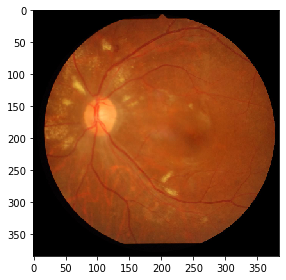

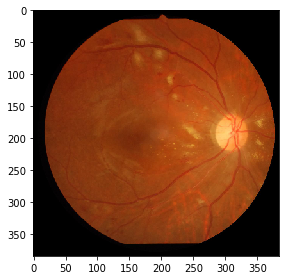

In [11]:
[xL, xR], y = imageGenerator(X_train[:, 0], X_train[:, 1], y_train, TRAIN_DIRECTORY, 1).__next__()
deZeroMean(xL, xR)
skimage.io.imshow(xL[0].astype(np.uint8))
skimage.io.show()
skimage.io.imshow(xR[0].astype(np.uint8))
skimage.io.show()


In [15]:
#One model version
K.clear_session()
gc.collect()
leftEyeInput = keras.Input(IMAGE_DIMS)
rightEyeInput = keras.Input(IMAGE_DIMS)
model = ResNet50V2(include_top=False, weights=None, pooling='max')
leftEye = model(leftEyeInput)
rightEye = model(rightEyeInput)
combined = Concatenate()([leftEye, rightEye])
out = Dense(NUM_CLASSES, activation='sigmoid')(combined)
model = Model([leftEyeInput, rightEyeInput], out)
model.summary()
img = plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=False, dpi=300)
model.compile(optimizer=OPTIMIZER,
              loss='binary_crossentropy',
              metrics=['accuracy']
              )

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
resnet50v2 (Model)              (None, 2048)         23564800    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 4096)         0           resnet50v2[1][0]             

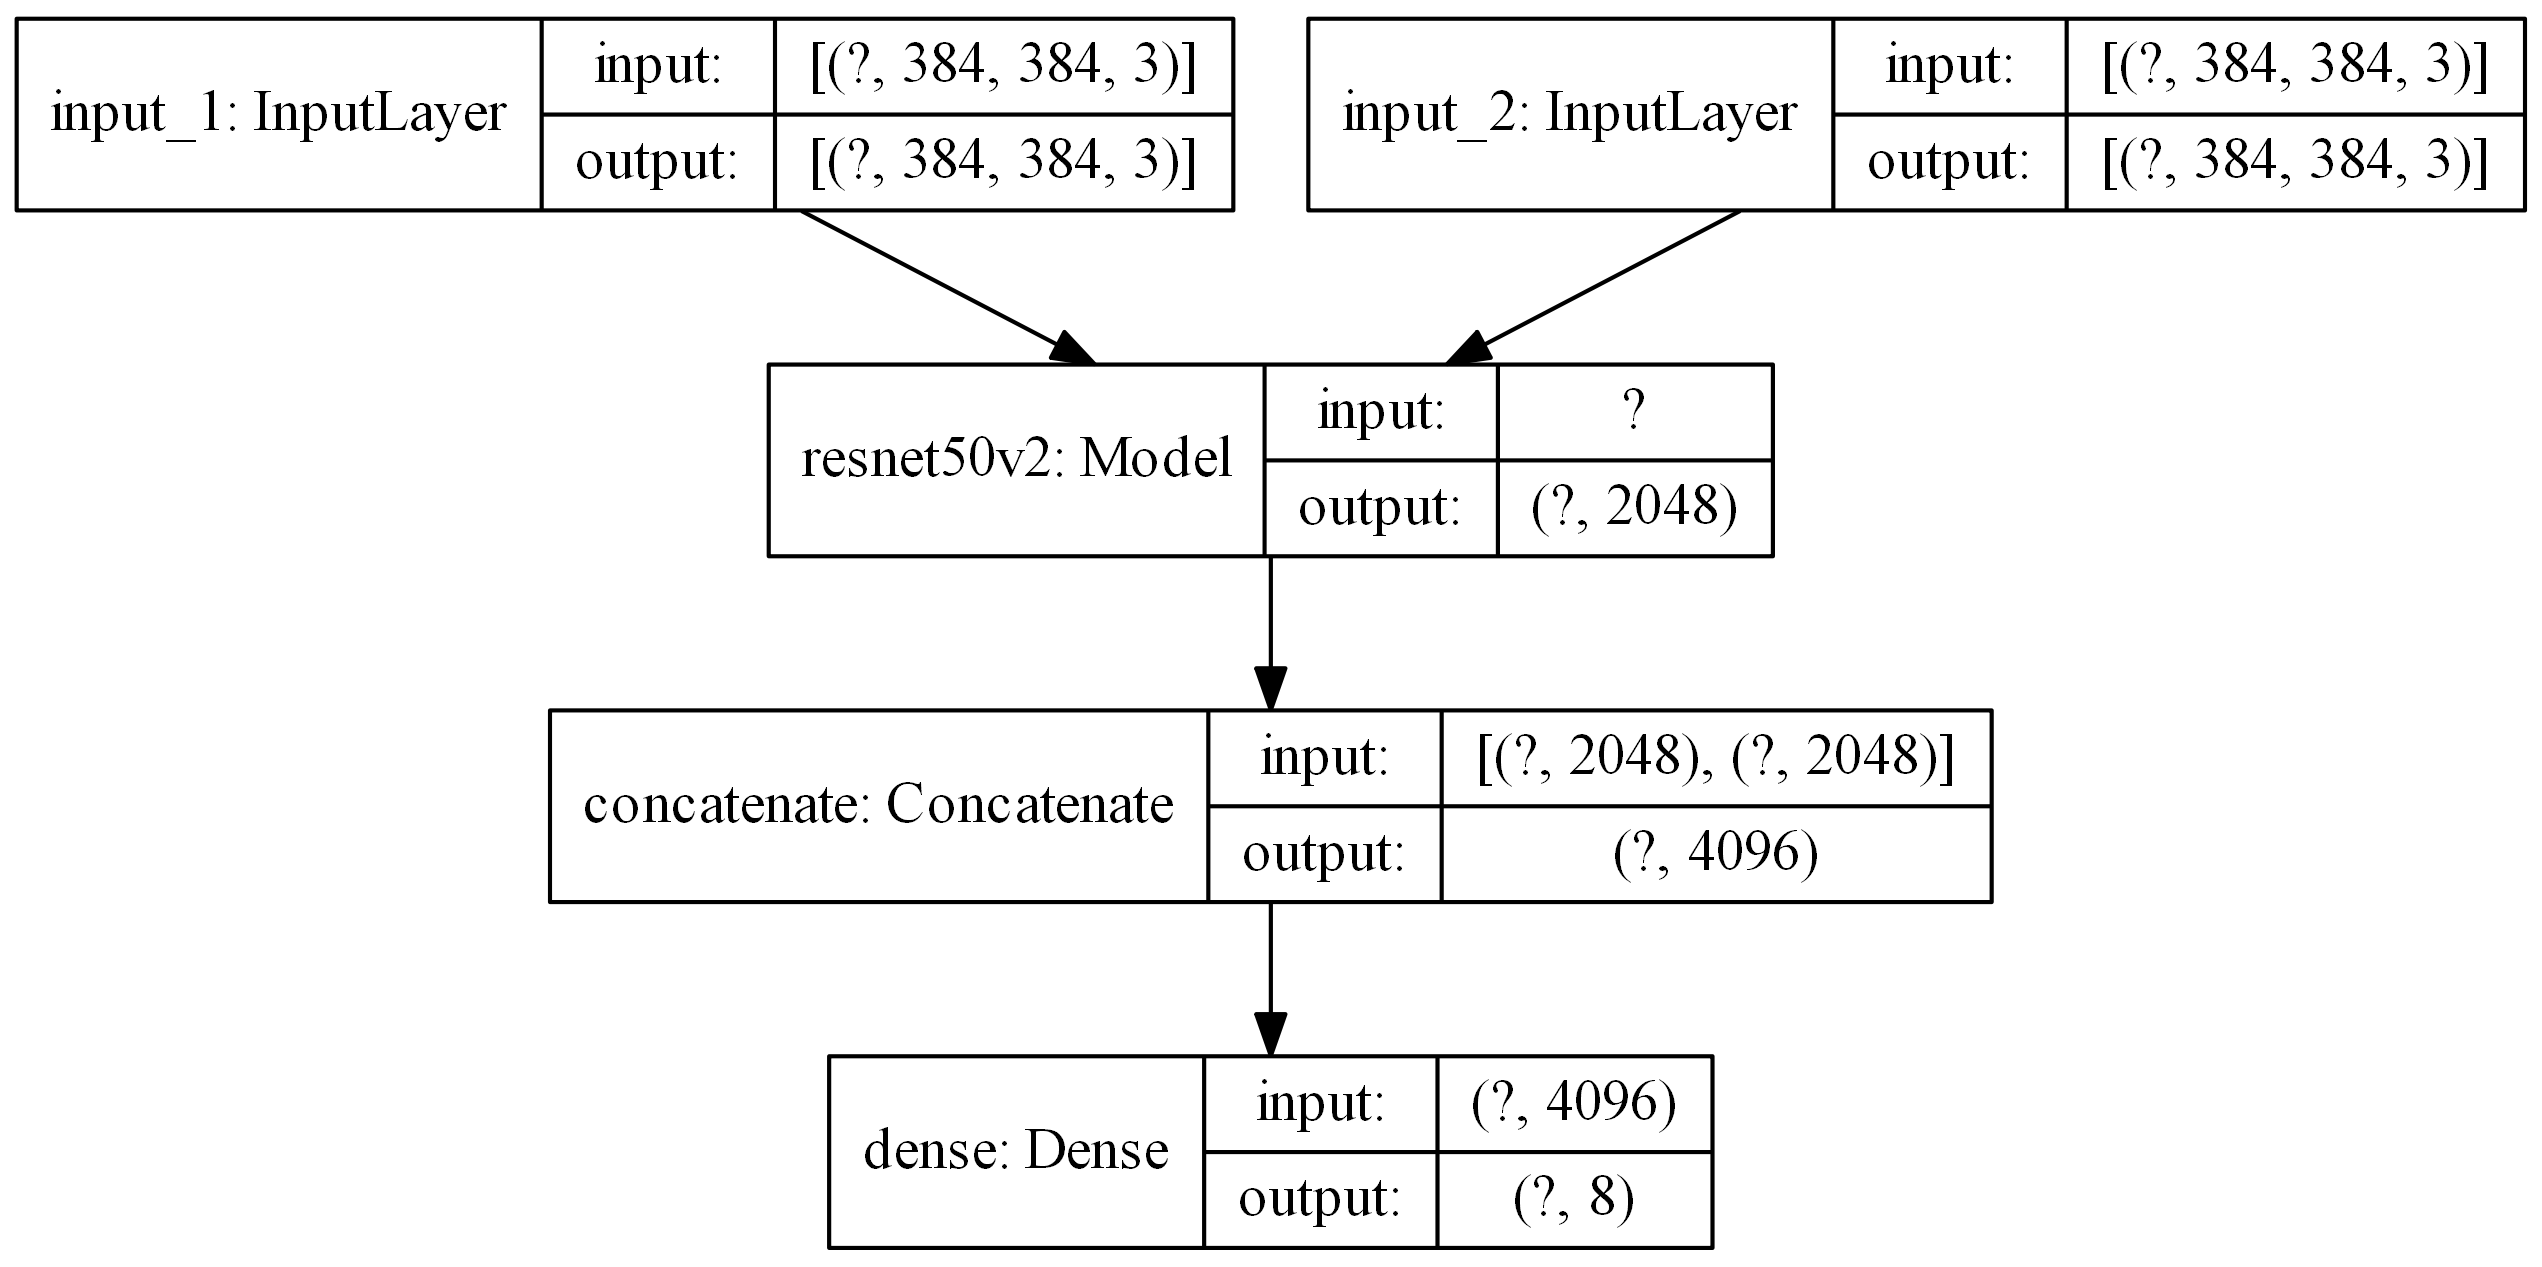

In [15]:
img

In [32]:
#VGG16/19 One Model Version
K.clear_session()
gc.collect()
leftEyeInput = keras.Input(IMAGE_DIMS)
rightEyeInput = keras.Input(IMAGE_DIMS)
model = VGG19(include_top=False, weights=None, pooling='max')
L = model(leftEyeInput)
R = model(rightEyeInput)
# flatten = Flatten()
# L = flatten(L)
# R = flatten(R)
dense = Dense(3000, activation='relu')
L = dense(L)
R = dense(R)
dense = Dense(3000, activation='relu')
L = dense(L)
R = dense(R)
combined = Concatenate()([L, R])
out = Dense(NUM_CLASSES, activation='sigmoid')(combined)
model = Model([leftEyeInput, rightEyeInput], out)
img = plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=False, dpi=300)
model.summary()
model.compile(optimizer=OPTIMIZER,
              loss='binary_crossentropy',
              metrics=['accuracy'], 
              )

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
vgg19 (Model)                   (None, 512)          20024384    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 3000)         1539000     vgg19[1][0]                  

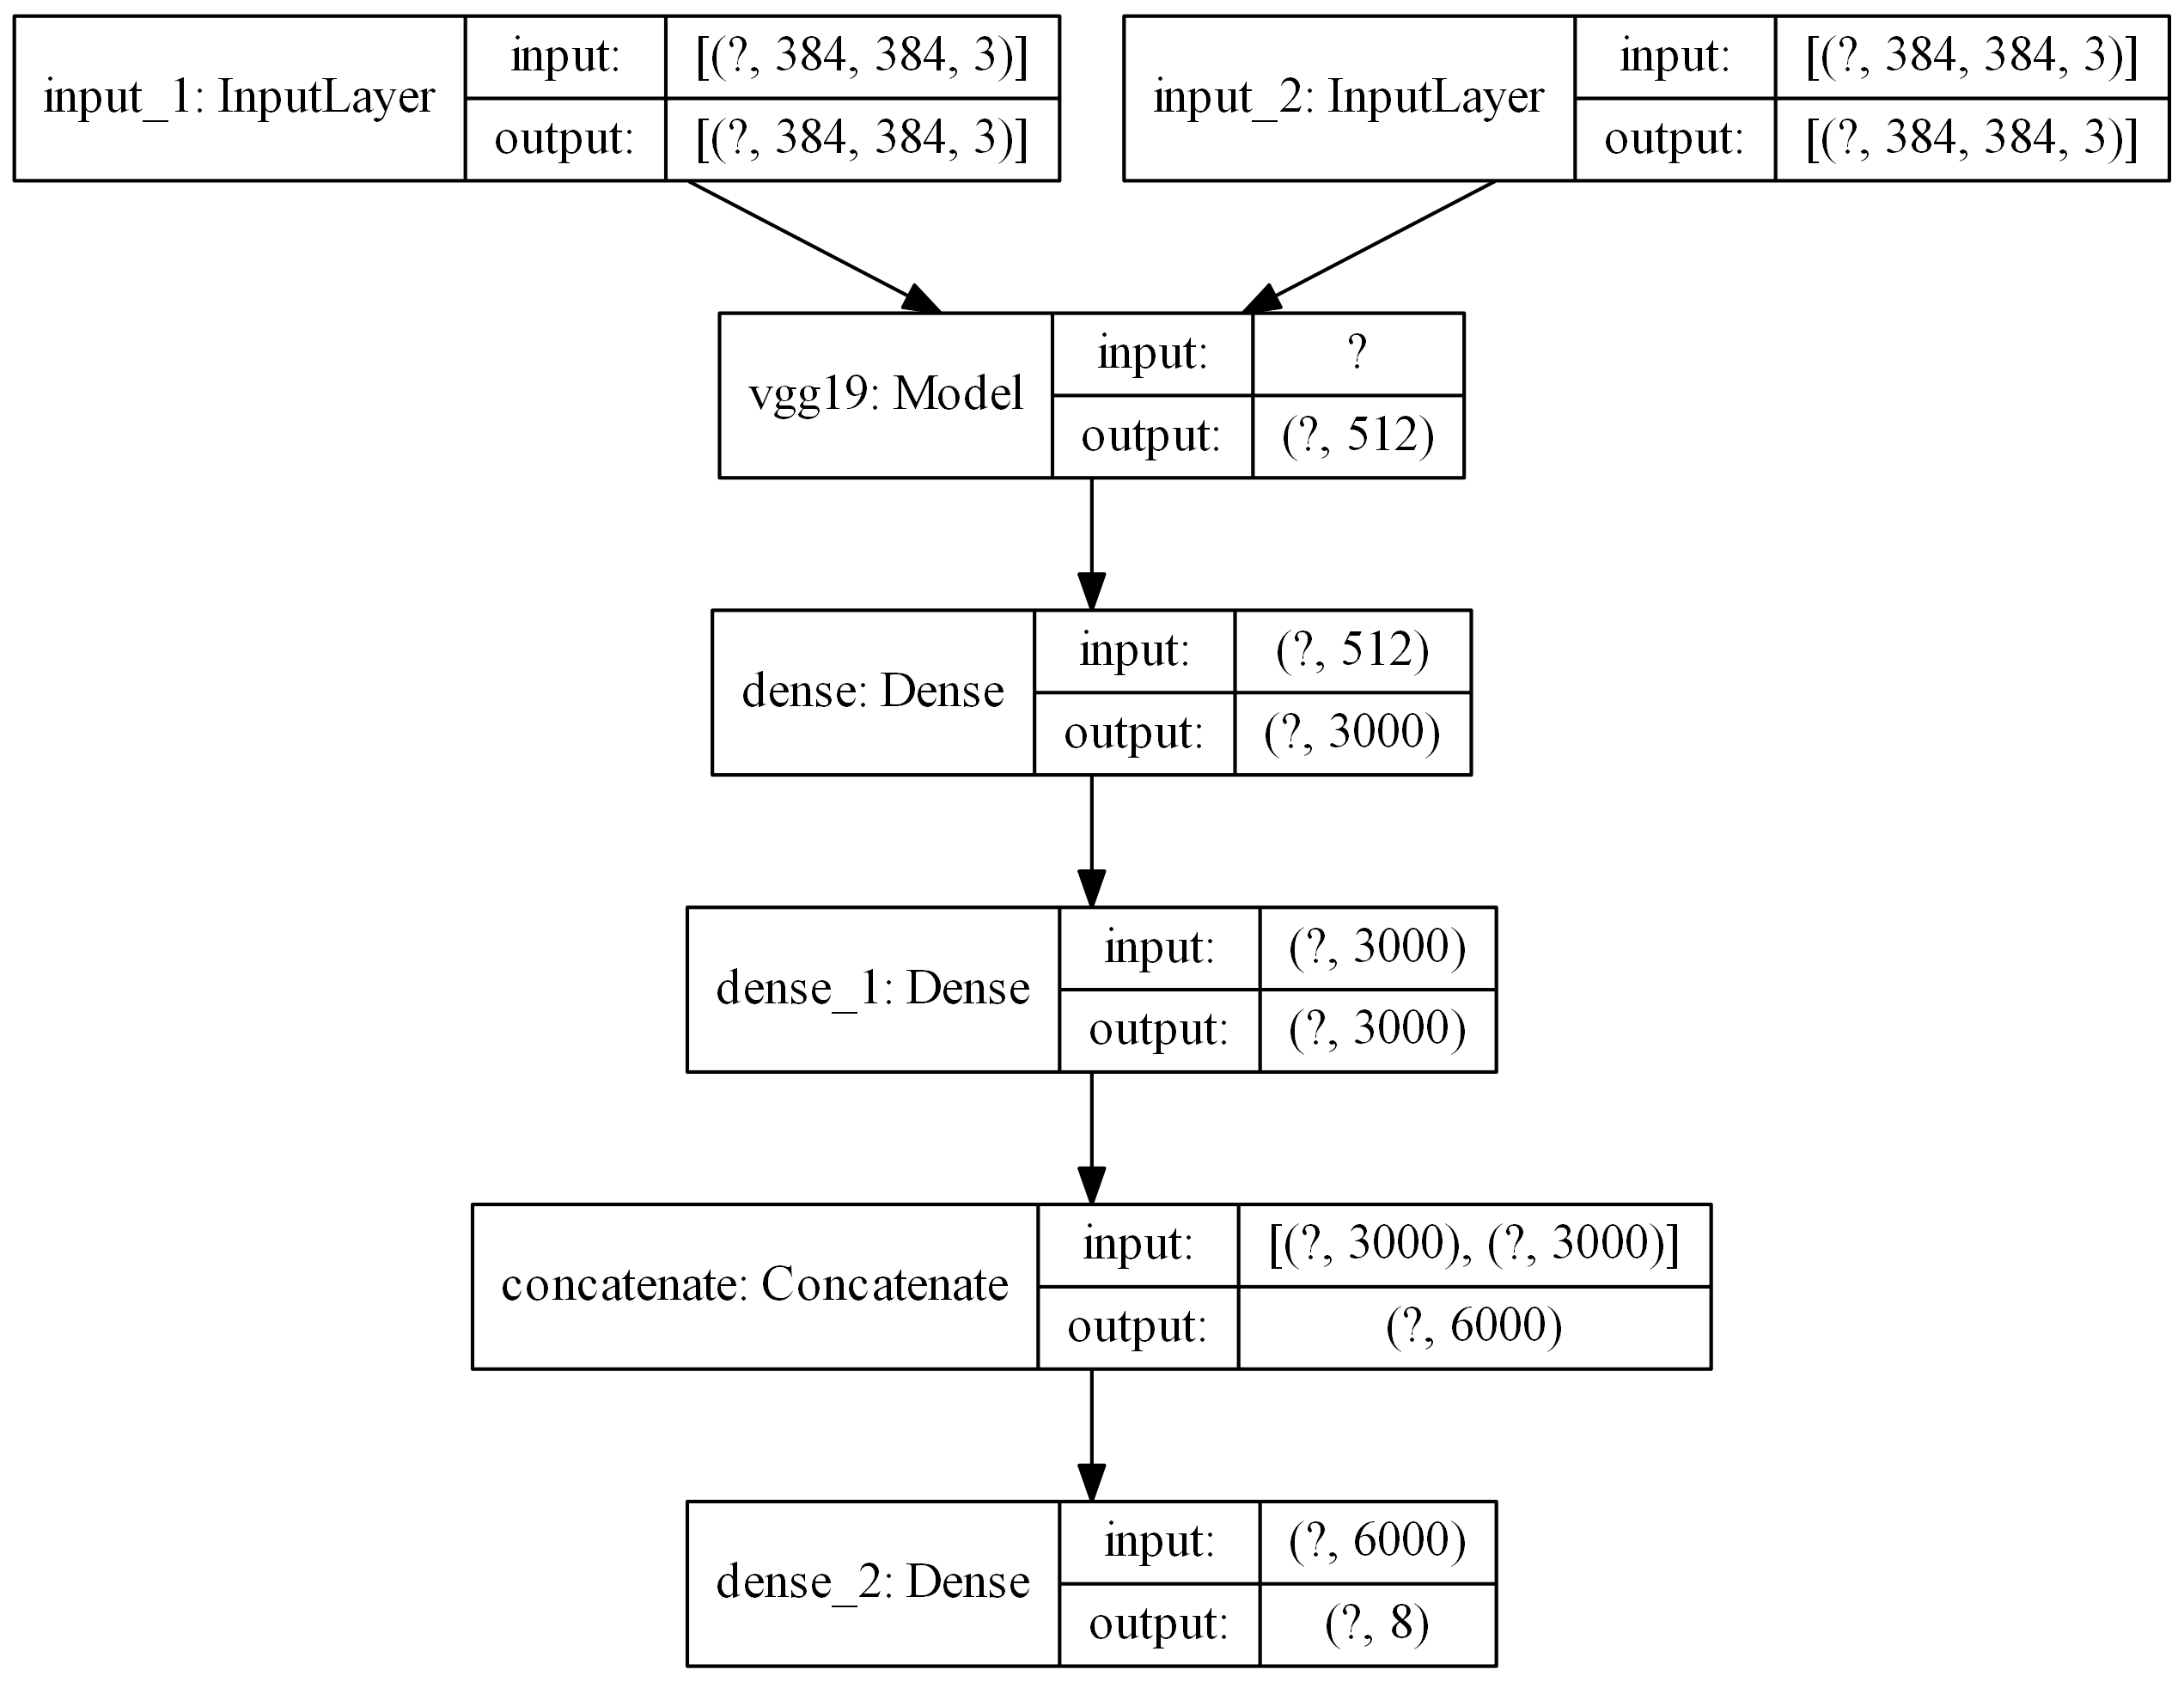

In [36]:
img

In [16]:
#Two model version
K.clear_session()
gc.collect()
leftEyeInput = keras.Input(IMAGE_DIMS)
rightEyeInput = keras.Input(IMAGE_DIMS)

leftEyemodel = ResNet50V2(input_tensor=leftEyeInput, include_top=False, weights=None, pooling='max')
rightEyemodel = ResNet50V2(input_tensor=rightEyeInput, include_top=False, weights=None, pooling='max')

leftEyemodel._name += "_left"
rightEyemodel._name += "_right"

combined = Concatenate()([leftEyemodel(leftEyeInput), rightEyemodel(rightEyeInput)])

out = Dense(NUM_CLASSES, activation='sigmoid')(combined)
model = Model([leftEyeInput, rightEyeInput], out)
model.summary()
img = plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=False, dpi=300)
model.compile(optimizer=OPTIMIZER,
              loss='binary_crossentropy',
              metrics=['accuracy']
              )

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
resnet50v2_left (Model)         (None, 2048)         23564800    input_1[0][0]                    
__________________________________________________________________________________________________
resnet50v2_right (Model)        (None, 2048)         23564800    input_2[0][0]                    
______________________________________________________________________________________________

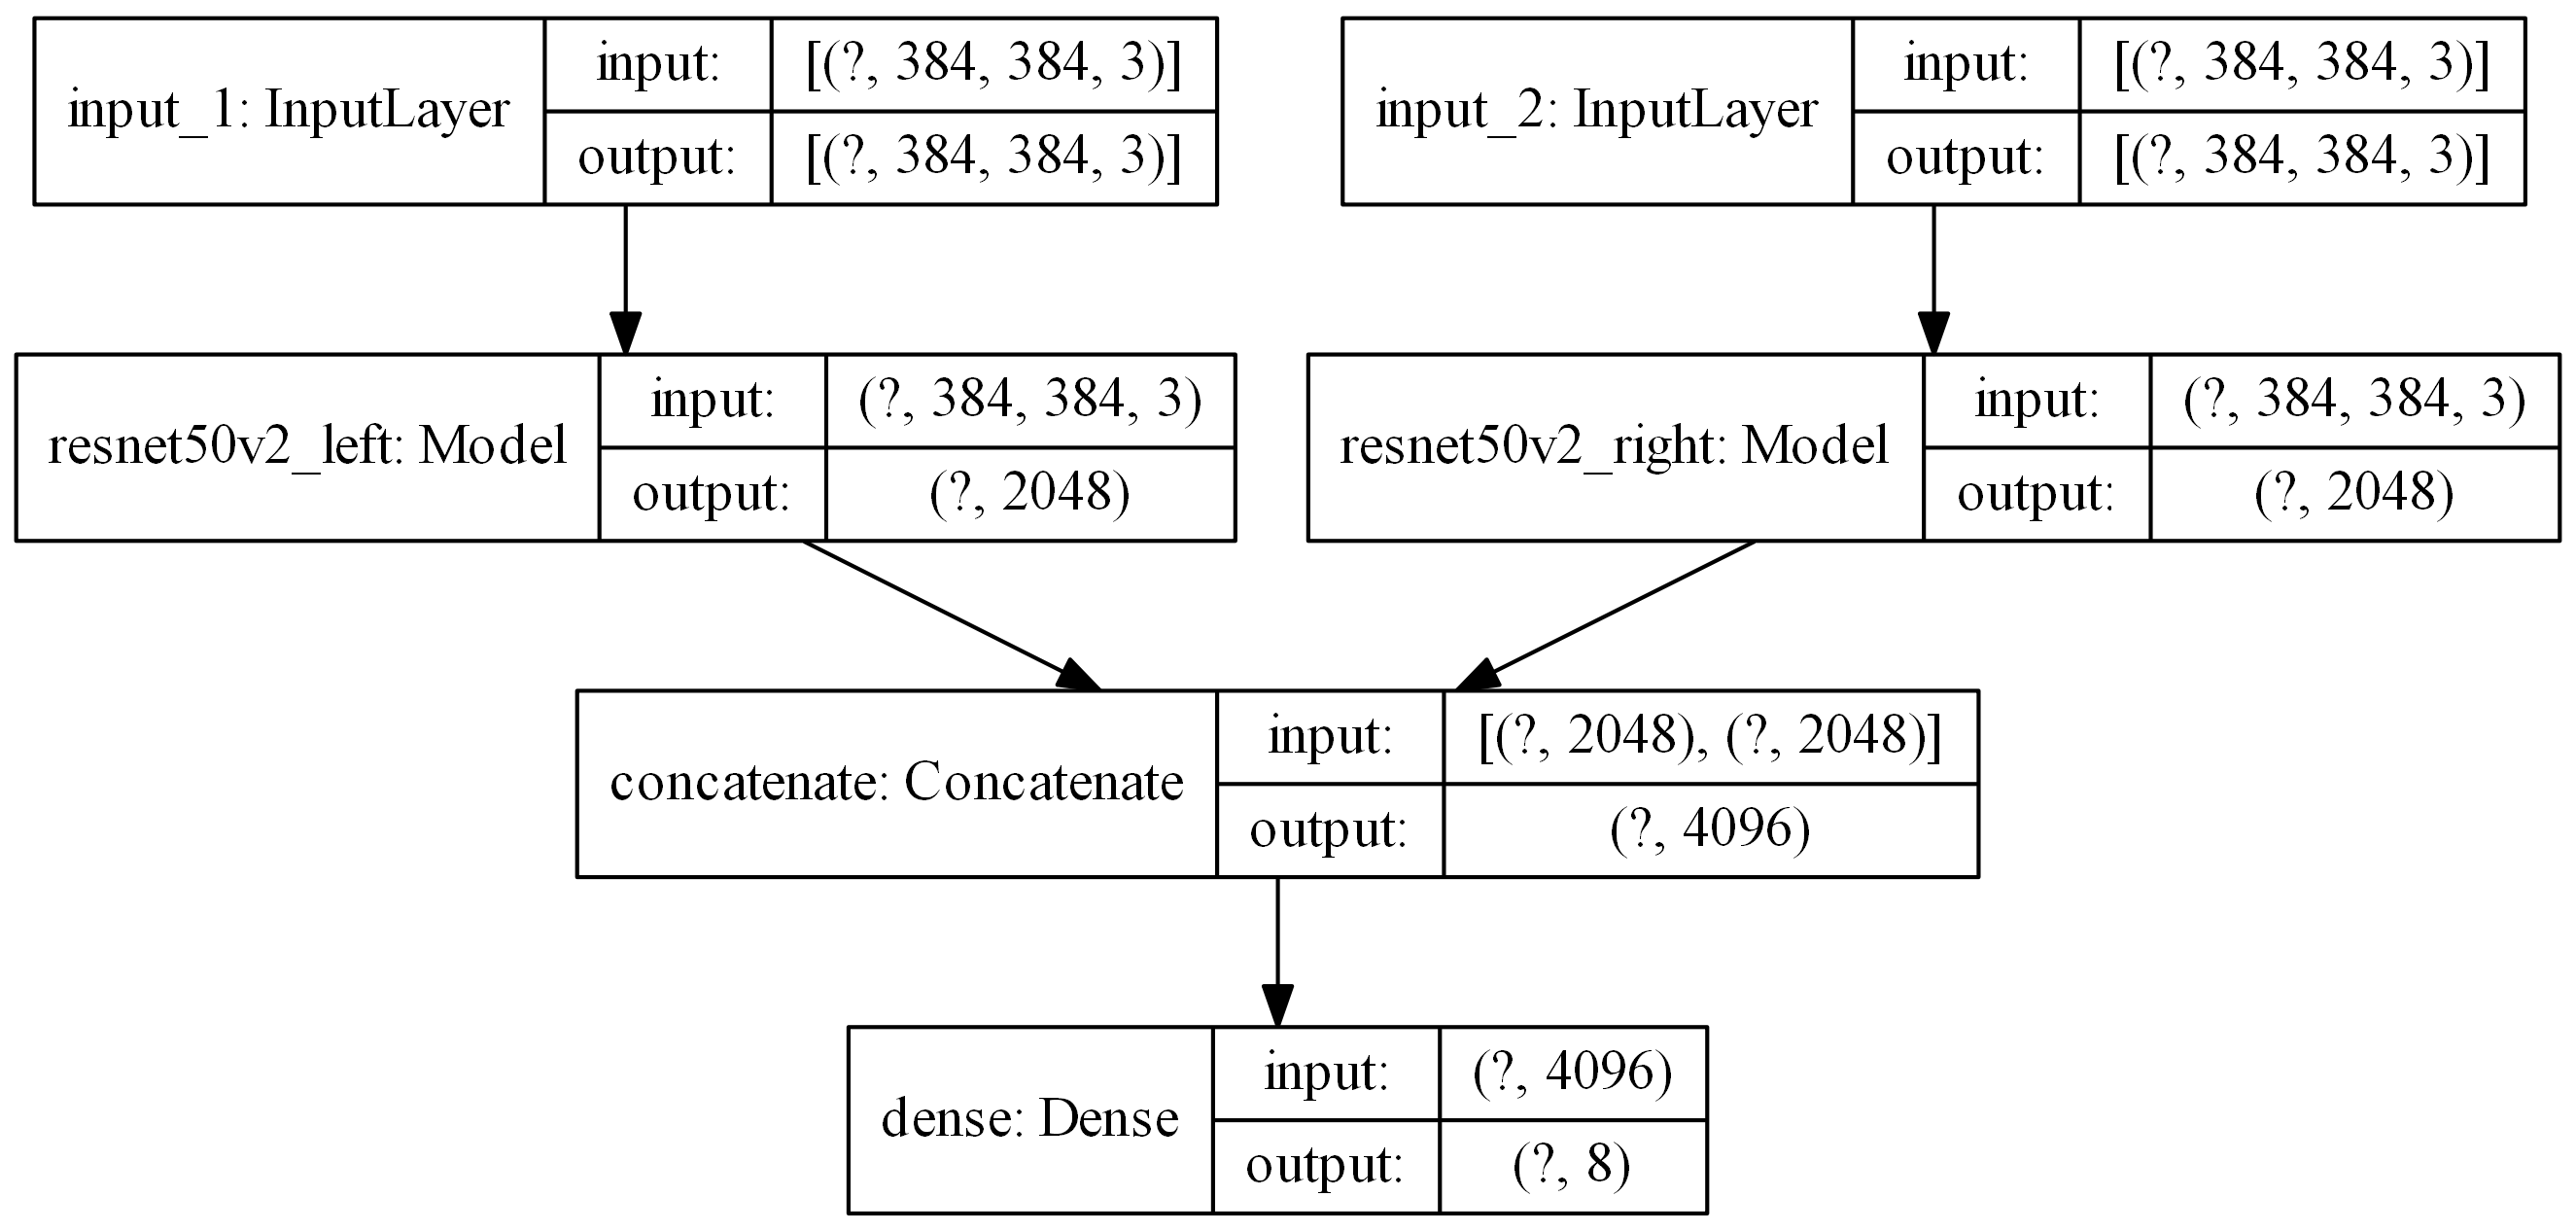

In [90]:
img

In [16]:
trainGen = imageGenerator(X_train[:, 0], X_train[:, 1], y_train, TRAIN_DIRECTORY, BATCH_SIZE)
valGen = imageGenerator(X_test[:, 0], X_test[:, 1], y_test, TRAIN_DIRECTORY, BATCH_SIZE)
tbCallback = TensorBoard(
    log_dir='logs',
    update_freq='epoch',
    write_graph=True,
)
weight_save_callback = keras.callbacks.ModelCheckpoint(
    MODEL_DIR + '{epoch:02d}-{val_loss:.2f}.h5', 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=False, 
    mode='auto'
    )

In [17]:
model.fit(trainGen, 
        epochs=NUM_EPOCHS,
        validation_data=valGen, 
        max_queue_size=100,
        class_weight=classWeights,
        callbacks = [weight_save_callback, tbCallback], 
        steps_per_epoch=TRAIN_STEPS, 
        validation_steps=TEST_STEPS
        )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 200 steps, validate for 50 steps
Epoch 1/500
200/200 [==============================] - 84s 421ms/step - loss: 0.9238 - accuracy: 0.8409 - val_loss: 0.6955 - val_accuracy: 0.8429
Epoch 2/500
200/200 [==============================] - 71s 357ms/step - loss: 0.6551 - accuracy: 0.8463 - val_loss: 0.7581 - val_accuracy: 0.8484
Epoch 3/500
200/200 [==============================] - 71s 353ms/step - loss: 0.7074 - accuracy: 0.8468 - val_loss: 0.7020 - val_accuracy: 0.8464
Epoch 4/500
200/200 [==============================] - 71s 354ms/step - loss: 0.6917 - accuracy: 0.8467 - val_loss: 0.8328 - val_accuracy: 0.8448
Epoch 5/500
200/200 [==============================] - 71s 357ms/step - loss: 0.7436 - accuracy: 0.8441 - val_loss: 0.8660 - val_accuracy: 0.8418
Epoch 6/500
200/200 [==============================] - 70s 351ms/step - loss: 0.6613 - accuracy: 0.8466 - val_loss: 0.5032 - val_accuracy: 0.8473
Epoch 7/500
200/200 [==========

Epoch 111/500
200/200 [==============================] - 70s 348ms/step - loss: 0.4108 - accuracy: 0.8471 - val_loss: 0.4217 - val_accuracy: 0.8439
Epoch 112/500
200/200 [==============================] - 70s 348ms/step - loss: 0.3813 - accuracy: 0.8471 - val_loss: 0.3532 - val_accuracy: 0.8404
Epoch 113/500
200/200 [==============================] - 70s 348ms/step - loss: 0.3962 - accuracy: 0.8468 - val_loss: 0.4411 - val_accuracy: 0.8504
Epoch 114/500
200/200 [==============================] - 70s 348ms/step - loss: 0.4083 - accuracy: 0.8483 - val_loss: 0.3965 - val_accuracy: 0.8450
Epoch 115/500
200/200 [==============================] - 70s 348ms/step - loss: 0.3716 - accuracy: 0.8476 - val_loss: 0.3815 - val_accuracy: 0.8464
Epoch 116/500
200/200 [==============================] - 70s 348ms/step - loss: 0.3876 - accuracy: 0.8476 - val_loss: 0.3362 - val_accuracy: 0.8518
Epoch 117/500
200/200 [==============================] - 70s 348ms/step - loss: 0.3771 - accuracy: 0.8474 - val_

KeyError: 'val_loss'

In [12]:
K.clear_session()
gc.collect()
MODEL_PATH = '20percentTest/166-0.37.h5'
model = keras.models.load_model(MODEL_PATH)

In [16]:
INIT_EPOCH = 35
model.fit(trainGen, 
        epochs=NUM_EPOCHS, 
        validation_data=valGen, 
        initial_epoch = INIT_EPOCH,
        class_weight=classWeights,
        max_queue_size=100,
#         callbacks = [weight_save_callback, tbCallback], 
        steps_per_epoch = X_train.shape[0] // BATCH_SIZE, 
        validation_steps = X_test.shape[0] // BATCH_SIZE
        )

NameError: name 'trainGen' is not defined

In [13]:
# trainGenTest = imageGeneratorResize(X_train[:, 0], X_train[:, 1], y_train, TRAIN_DIRECTORY, 4)
trainGen = imageGenerator(X_train[:, 0], X_train[:, 1], y_train, RESIZED_DIRECTORY, 50)
# valGenTest = imageGeneratorResize(X_test[:, 0], X_test[:, 1], y_test, TRAIN_DIRECTORY, 4)

In [17]:
X, y = trainGen.__next__()
xL, xR = X
deZeroMean(xL, xR)
results = model.predict(X)

bin_results = results > 0.5
bin_y = y > 0.5
numcorrect = (bin_results == bin_y).sum()
total = bin_results.size

print(model.evaluate(X, y))
print(numcorrect, total)
print(numcorrect/total)

50/50 [==============================] - 2s 30ms/sample - loss: 0.3927 - accuracy: 0.8625
[0.39268251180648805, 0.8625]
345 400
0.8625


In [18]:
bin_results

array([[ True, False, False, False, False, False, False,  True],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, Fal

In [ ]:
bin_y

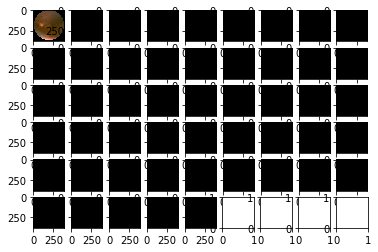

In [39]:
w=10
h=5
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


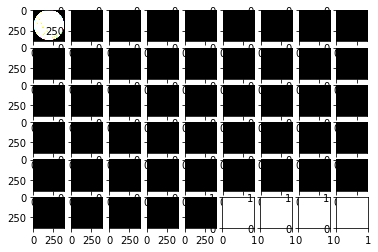

In [23]:
skimage.io.imshow_collection(xR)
skimage.io.show()